In [19]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from numpy import log, log1p
from scipy.stats import boxcox
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder
from pandas import get_dummies
from sklearn.ensemble import RandomForestClassifier

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

df = train.drop(['PassengerId'], axis=1).copy()
data = df.copy()
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Anlysis

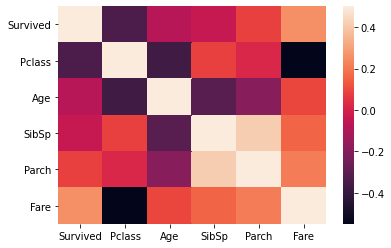

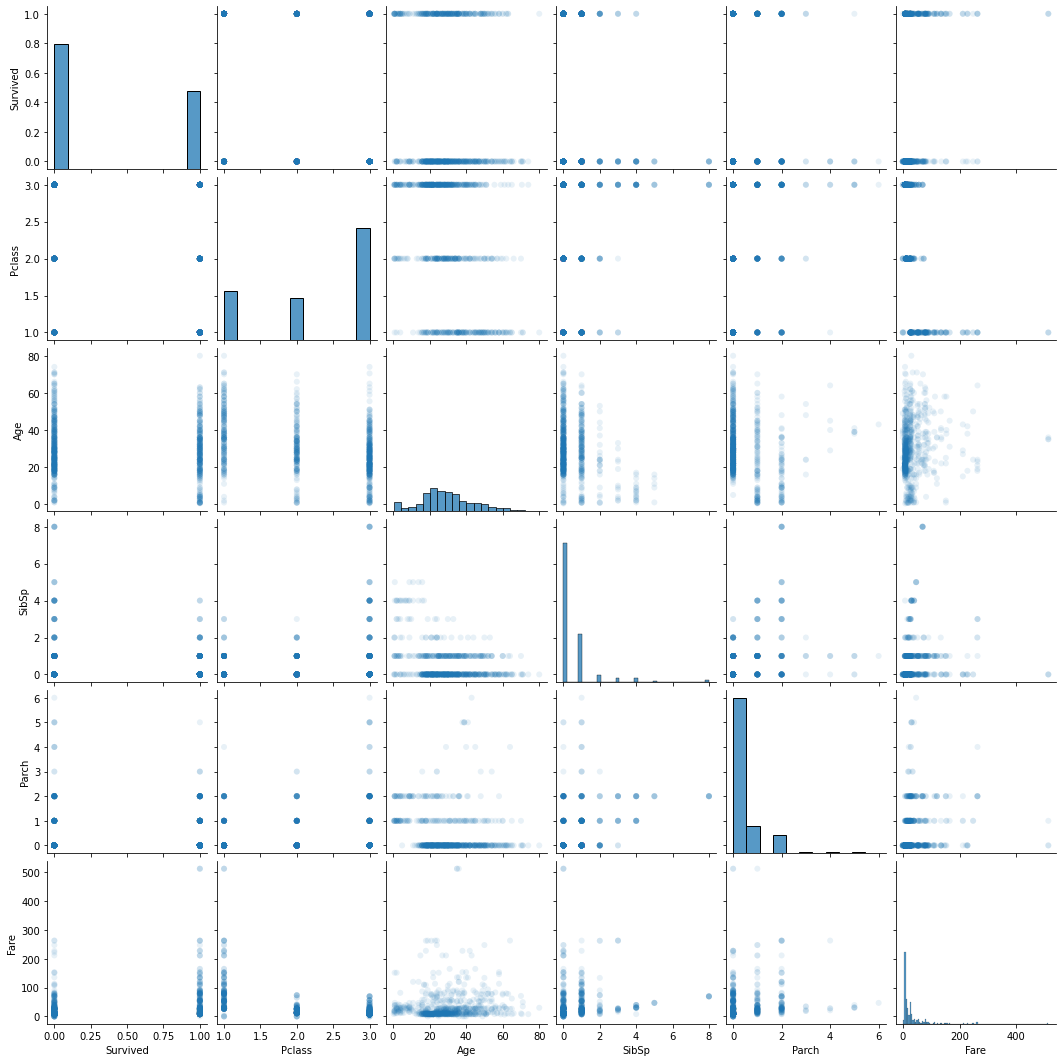

In [20]:
numcols = data.select_dtypes('number').columns
numdata = data[numcols]

sns.heatmap(numdata.corr(), vmax=0.5)
sns.pairplot(df, plot_kws=dict(alpha=0.1, edgecolor='none'))
plt.show()

Pairplots and heatmap show a high survival rate between the ages of around 18-40, and those who paid higher Fare were also more likely to survive.
Pclass has a negative correlation due to numbering style, but is one of the biggest predictors of survival.

Exploring the correlation between age groups, sex and survival:

c:\users\lkphy\desktop\comp\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\lkphy\desktop\comp\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\lkphy\desktop\comp\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

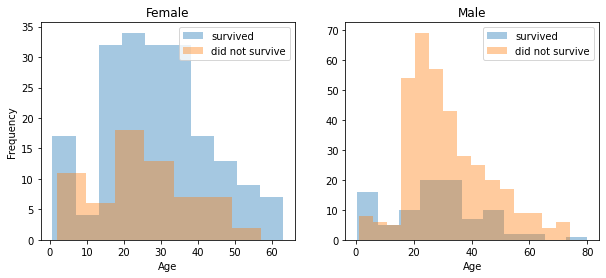

In [21]:
male = df[df['Sex'] == 'male']
female = df[df['Sex'] == 'female']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = sns.distplot(female[female['Survived'] == 1].Age, ax=axes[0], label='survived', kde=False)
ax = sns.distplot(female[female['Survived'] == 0].Age, ax=axes[0], label='did not survive', kde=False)
ax.set(title='Female', ylabel='Frequency')
ax.legend()
ax = sns.distplot(male[male['Survived'] == 1].Age, ax=axes[1], label='survived', kde=False)
ax = sns.distplot(male[male['Survived'] == 0].Age, ax=axes[1], label='did not survive', kde=False)
ax.set(title='Male')
ax.legend()
plt.show()

We can see the survival rate in females between around 15-30 is high, but the opposite is true for males.
Male mortality rate is highest between 18-30, with the highest survival rate in males falling in the 25-35 age group
and in the infant category. Key to survival was being female mostly.

imilar Graph for ticket class shows that for both sexes, being 3rd class had by far the greatest death rate.

c:\users\lkphy\desktop\comp\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\lkphy\desktop\comp\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\lkphy\desktop\comp\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

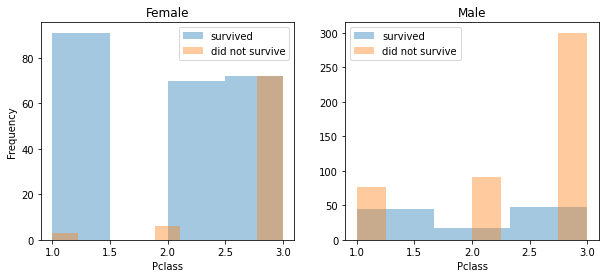

In [22]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = sns.distplot(female[female['Survived'] == 1].Pclass, ax=axes[0], label='survived', kde=False)
ax = sns.distplot(female[female['Survived'] == 0].Pclass, ax=axes[0], label='did not survive', kde=False)
ax.set(title='Female', ylabel='Frequency')
ax.legend()
ax = sns.distplot(male[male['Survived'] == 1].Pclass, ax=axes[1], label='survived', kde=False)
ax = sns.distplot(male[male['Survived'] == 0].Pclass, ax=axes[1], label='did not survive', kde=False)
ax.set(title='Male')
ax.legend()
plt.show()

# Feature Engineering

In [23]:
sex = {'male': 0, 'female': 1}
df['Sex'] = df['Sex'].map(sex)
test['Sex'] = test['Sex'].map(sex)

df.isnull().sum().sort_values(ascending=False)

Cabin       687
Age         177
Embarked      2
Survived      0
Pclass        0
Name          0
Sex           0
SibSp         0
Parch         0
Ticket        0
Fare          0
dtype: int64

In [24]:
#

test['Fare'] = test['Fare'].fillna(0)

cabinlist = {'n': 0, 'C': 1, 'E': 2, 'G': 3, 'D': 4, 'A': 5, 'B': 6, 'F': 7, 'T': 8}

def cabins(df):
    df.Cabin.fillna('T', inplace=True)
    df['Cabin'] = df['Cabin'].astype(str).str[0]
    df['Cabin'] = df['Cabin'].map(cabinlist)
    cabin_dummies = pd.get_dummies(df['Cabin'], prefix='Cabin')
    df = pd.concat([df, cabin_dummies], axis=1)
    df.drop('Cabin', axis=1, inplace=True)
    return df

Grouping Titles into Mr, Mrs, Miss and other variants

In [25]:
titles = {'Mr': 'Mr', 'Mrs':'Mrs', 'Miss': 'Miss', 'Master':'Master', 'Don':'Other', 'Rev':'Other', 'Dr':'Other', 'Mme': 'Mrs', 'Ms':'Mrs',
          'Major':'Other', 'Lady':'Upper', 'Sir':'Other', 'Mlle':'Miss', 'Col':'Other', 'Capt':'Other', 'the Countess':'Upper',
          'Jonkheer':'Upper', 'Dona':'Upper'}


def title(df):
    df['Title'] = df.Name.str.extract(r',\s*([^\.]*)\s*\.', expand=False)
    df['Title'] = df.Title.map(titles)
    title_dummies = pd.get_dummies(df['Title'], prefix='Title')
    df = pd.concat([df, title_dummies], axis=1)
    return df

Creating numerical values and columns for the embarked data, using dummies and the onehot encoding method

In [26]:
def embarked(df):
    df['Embarked'] = df['Embarked'].fillna('S')
    embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df.drop(['Embarked'], axis=1, inplace=True)
    df = pd.concat([df, embarked_dummies], axis=1)
    return df

In [27]:
df.head()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S


When dealing with NaN values in Age, it was tempting to simply fill these with the mean age but after
some reading and some thought, decided to fill these values based on the relationship between ages and titles. Based on
the title for the passenger, an age group was predicted and then a mean was taken from that age group to assign a value.

In [28]:
def age(df):
    for title in df['Title']:
        if title == 'Master':  # boy
            df['Age'] = df['Age'].fillna(df[df['Age'] < 18].Age.mean())

        if title == 'Mr':  # Male or female adult
            df['Age'] = df['Age'].fillna(df[df['Age'] >= 18].Age.mean())

        if title == 'Other':  # Generally high ranking positions in army, dr, reverend etc likely to be over 30
            df['Age'] = df['Age'].fillna(df[df['Age'] >= 40].Age.mean())

        if title == 'Upper':
            df['Age'] = df['Age'].fillna(df[df['Age'] >= 30].Age.mean())

        if title == 'Miss':
            df['Age'] = df['Age'].fillna(df[df['Age'] < 25].Age.mean())

        if title == 'Mrs':
            df['Age'] = df['Age'].fillna(df[df['Age'] >= 25].Age.mean())


    df['Age'] = df['Age'].astype(int)
    df.loc[df['Age'] <= 10, 'Age'] = 0
    df.loc[(df['Age'] <= 20) & (df['Age'] > 10), 'Age'] = 1
    df.loc[(df['Age'] <= 30) & (df['Age'] > 20), 'Age'] = 2
    df.loc[(df['Age'] <= 40) & (df['Age'] > 30), 'Age'] = 3
    df.loc[(df['Age'] <= 50) & (df['Age'] > 40), 'Age'] = 4
    df.loc[(df['Age'] <= 60) & (df['Age'] > 50), 'Age'] = 5
    df.loc[(df['Age'] <= 70) & (df['Age'] > 60), 'Age'] = 6
    df.loc[(df['Age'] <= 80) & (df['Age'] > 70), 'Age'] = 7
    return(df)

In [29]:
df = title(df)
test = title(test)
df = age(df)
test = age(test)

Including propagating metrics such as family size as the combination of sibling count and number of parents, and the
relationship between age and class:

In [30]:
df['Family Size'] = df['SibSp'] + df['Parch']
df['AgexClass'] = df['Age'] * df['Pclass']

test['Family Size'] = test['SibSp'] + test['Parch']
test['AgexClass'] = test['Age'] * test['Pclass']

Predictions using Random Forest


In [31]:
X_train = df.drop(['Survived', 'Name', 'Ticket'], axis=1)
Y_train = df['Survived']
X_test = test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

random_forest = RandomForestClassifier(n_estimators=5, max_features=3, max_depth=3, min_samples_split=2, random_state=0)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

ValueError: could not convert string to float: 'C85'

Kaggle Score: 78%

